# PPO, R-PPO and VAE comparison

## Frauds in the dataset
We compute how much money a fraudster is able to collect with a card in the simulator.

from parameters import CardSimParameters, Parameters

params = Parameters(cardsim=CardSimParameters.paper_params())
env = params.create_env()
banksys = env.system

## Score over training time

In [1]:
import numpy as np

anomaly = True

if anomaly:
    logdirs = {
        "Mimicry": "../logs/anomaly/vae/2025-09-19T15-46-05.846486",
        "FRAUD-RLA": "../logs/anomaly/ppo/2025-09-19T09-43-04.501028",
        "R-FRAUD-RLA": "../logs/anomaly/rppo/2025-09-19T13-05-17.374379",
    }
else:
    logdirs = {
        "Mimicry": "logs/no-anomaly/no-anomaly/vae/2025-09-19T16-41-07.764246",
        "FRAUD-RLA": "logs/no-anomaly/no-anomaly/ppo/2025-09-19T11-40-32.971413",
        "R-FRAUD-RLA": "logs/no-anomaly/no-anomaly/rppo/2025-09-19T14-08-14.120200"
    }

    
def moving_average(data, window_size: int):
    """Compute the moving average of a 1D array."""
    return np.convolve(data, np.ones(window_size) / window_size, mode="valid")


{'Mimicry': 'logs/anomaly/vae/2025-09-19T15-46-05.846486', 'FRAUD-RLA': 'logs/anomaly/ppo/2025-09-19T09-43-04.501028', 'R-FRAUD-RLA': 'logs/anomaly/rppo/2025-09-19T13-05-17.374379'}


# Average amount per card over the course of the training

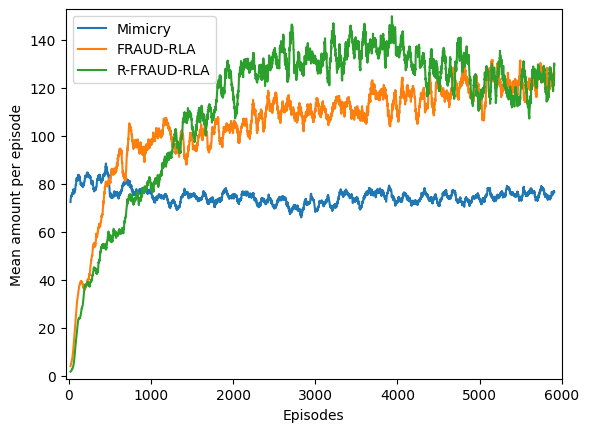

In [3]:
import matplotlib.pyplot as plt
from plots import Experiment

window_size = 50
for label, logdir in logdirs.items():
    exp = Experiment.load(logdir)
    mean, _ = exp.mean_std_amounts_over_time
    mean = moving_average(mean, window_size)
    # std = moving_average(std, window_size)
    # ci95 = 1.96 * std / np.sqrt(exp.n_runs)
    mean[:20] = np.nan
    mean[-40:] = np.nan
    
    plt.plot(mean, label=label)
    #plt.fill_between(range(len(mean)), mean - ci95, mean + ci95, alpha=0.2)
plt.legend()
plt.margins(x=0.01, y=0.02)
plt.xticks([0, 1000, 2000, 3000, 4000, 5000, 6000])
plt.xlabel("Episodes")
plt.ylabel("Mean amount per episode")
plt.savefig("amount-over-time_anomaly.svg")

# Cumulated amount over the course of the training

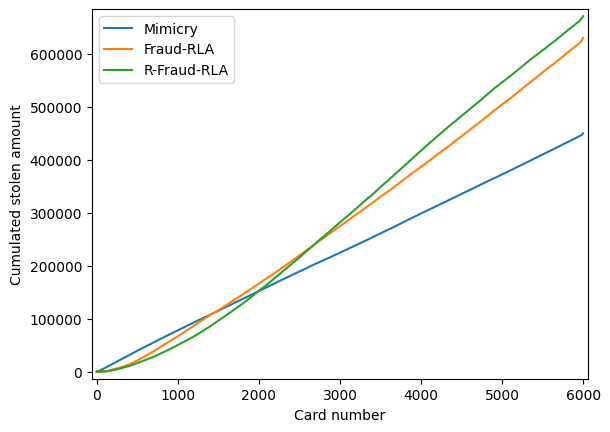

In [51]:
import matplotlib.pyplot as plt
from plots import Experiment
import numpy as np

window_size = 50
for label, logdir in logdirs.items():
    exp = Experiment.load(logdir)
    mean, _ = exp.mean_std_amounts_over_time
    cumsum = np.cumsum(mean)
    plt.plot(cumsum, label=label)
    # plt.fill_between(range(len(mean)), mean - ci95, mean + ci95, alpha=0.2)
plt.legend()
plt.margins(x=0.01, y=0.02)
plt.xticks([0, 1000, 2000, 3000, 4000, 5000, 6000])
plt.xlabel("Card number")
plt.ylabel("Cumulated stolen amount")
plt.savefig("cumulated-amount.svg")


# Total amount collected

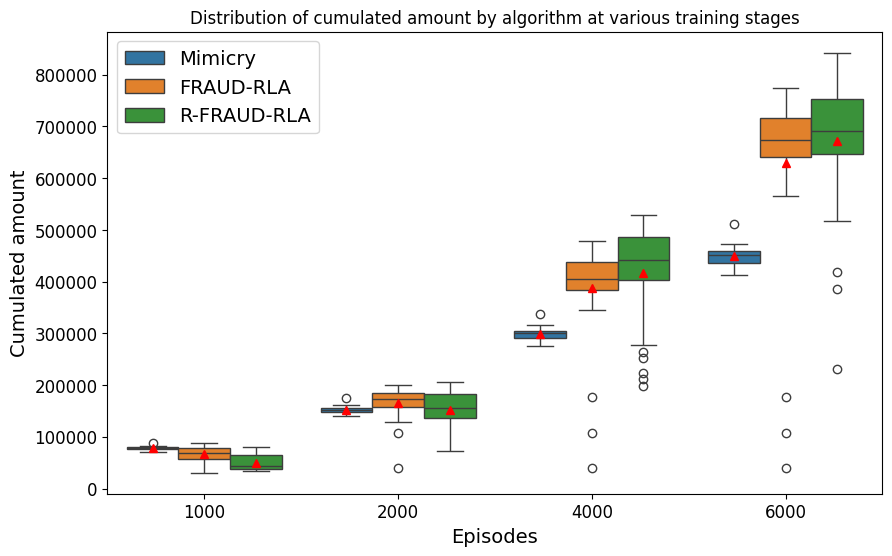

In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Dictionary to store results
results = {
    "Label": [],
    "Episodes": [],
    "Mean": [],
    # "Variance": []
}

# Long-form storage for boxplots
all_values = {
    "Label": [],
    "Episodes": [],
    "Value": [],
}

for label, logdir in logdirs.items():
    exp = Experiment.load(logdir)
    amounts = exp.amounts_over_time  # shape: (n_runs, n_episodes)
    for episodes in [1000, 2000, 4000, 6000]:
        cumulated_amounts = [sum(run.amount_over_time[:episodes]) for run in exp.runs.values()]
        mean = np.mean(cumulated_amounts)
        #cumulated = np.sum(amounts[:, :episodes], axis=1)
        #mean = int(np.mean(cumulated))

        # Store summary stats
        results["Label"].append(label)
        results["Mean"].append(mean)

        # Store all values for plotting
        all_values["Label"].extend([label] * len(cumulated_amounts))
        all_values["Episodes"].extend([episodes] * len(cumulated_amounts))
        all_values["Value"].extend(cumulated_amounts)

# Convert to DataFrames
#results_df = pd.DataFrame(results)
all_values_df = pd.DataFrame(all_values)

# print(results_df)

# --- Plot boxplots ---
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=all_values_df,
    x="Episodes",
    y="Value",
    hue="Label",
    showmeans=True,
    showfliers=True,
    meanprops={"markerfacecolor": "red", "markeredgecolor": "red"},
)
plt.title("Distribution of cumulated amount by algorithm at various training stages")
plt.ylabel("Cumulated amount", fontsize=14)
plt.xlabel("Episodes", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=14)
plt.savefig("Final_boxplots.svg")
plt.show()


# Cause of detection

In [2]:
from plots import Experiment
import polars as pl
from tqdm import tqdm

rows = []
for label, logdir in logdirs.items():
    print(label)
    exp = Experiment.load(logdir)
    for run in tqdm(list(exp.runs.values())[:5]):
        for i, episode in enumerate(run.load_episodes()):
            rows.append(episode.metrics | {"t": i, "label": label})
    
df = pl.DataFrame(rows)
df.describe()

Mimicry


100%|██████████| 5/5 [00:02<00:00,  2.19it/s]


FRAUD-RLA


100%|██████████| 5/5 [00:01<00:00,  4.02it/s]


R-FRAUD-RLA


100%|██████████| 5/5 [00:01<00:00,  2.55it/s]


statistic,t_start,card_id,t,BRF,Statistical,Rules,Rule: card_n_trx_last_1:00:00 < 5,"Rule: card_n_trx_last_1 day, 0:00:00 < 19","Rule: card_n_trx_last_7 days, 0:00:00 < 27",amount > 585.79 or < 0.08,"terminal_risk_last_1 day, 0:00:00 > 0.6666666666666666 or < 0.0",Anomaly,episode_len,score-0,label
str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str
"""count""","""85270""",85270.0,85270.0,75398.0,75398.0,75398.0,75398.0,75398.0,75398.0,75398.0,75398.0,75398.0,85270.0,85270.0,"""85270"""
"""null_count""","""0""",0.0,0.0,9872.0,9872.0,9872.0,9872.0,9872.0,9872.0,9872.0,9872.0,9872.0,0.0,0.0,"""0"""
"""mean""",null,10021.55845,2964.276006,0.331998,0.021658,0.0,0.0,0.0,0.0,0.021539,0.000119,0.772222,2.035874,103.737222,null
"""std""",null,5774.468796,1743.393197,0.470933,0.145566,0.0,0.0,0.0,0.0,0.145174,0.010925,0.419401,1.370513,151.308798,null
"""min""","""2023-06-30T00:01:47""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,"""FRAUD-RLA"""
"""25%""",null,5025.0,1431.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,null
"""50%""",null,10038.0,2954.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,38.110001,null
"""75%""",null,15027.0,4477.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,147.050003,null
"""max""","""2024-12-13T11:42:07.400463""",19999.0,5999.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,14.0,1119.97998,"""R-FRAUD-RLA"""


In [6]:
import matplotlib.pyplot as plt

causes = ["BRF", "Statistical", "Rules"]
for (label, *_), group in df.group_by("label"):
    print(label)
    x = group.select(pl.sum("BRF"), pl.sum("Statistical"), pl.sum("Rules"))
    res = x.with_columns(Customer=(pl.lit(group.height) - pl.sum_horizontal("*")), n_trx=pl.lit(group.height))
    print(res)

FRAUD-RLA
shape: (1, 5)
┌───────┬─────────────┬───────┬──────────┬───────┐
│ BRF   ┆ Statistical ┆ Rules ┆ Customer ┆ n_trx │
│ ---   ┆ ---         ┆ ---   ┆ ---      ┆ ---   │
│ i64   ┆ i64         ┆ i64   ┆ i64      ┆ i32   │
╞═══════╪═════════════╪═══════╪══════════╪═══════╡
│ 12065 ┆ 116         ┆ 0     ┆ 13089    ┆ 25270 │
└───────┴─────────────┴───────┴──────────┴───────┘
Mimicry
shape: (1, 5)
┌─────┬─────────────┬───────┬──────────┬───────┐
│ BRF ┆ Statistical ┆ Rules ┆ Customer ┆ n_trx │
│ --- ┆ ---         ┆ ---   ┆ ---      ┆ ---   │
│ i64 ┆ i64         ┆ i64   ┆ i64      ┆ i32   │
╞═════╪═════════════╪═══════╪══════════╪═══════╡
│ 56  ┆ 4           ┆ 0     ┆ 29940    ┆ 30000 │
└─────┴─────────────┴───────┴──────────┴───────┘
R-FRAUD-RLA
shape: (1, 5)
┌───────┬─────────────┬───────┬──────────┬───────┐
│ BRF   ┆ Statistical ┆ Rules ┆ Customer ┆ n_trx │
│ ---   ┆ ---         ┆ ---   ┆ ---      ┆ ---   │
│ i64   ┆ i64         ┆ i64   ┆ i64      ┆ i32   │
╞═══════╪═════════════╪═

## Number of transactions per card over time

import matplotlib.pyplot as plt
from plots import Experiment


for label, logdir in logdirs.items():
    exp = Experiment.load(logdir)
    print(f"There are {exp.n_runs} runs in {label}")
    data = exp.n_transactions_over_time
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    mean = moving_average(mean, window_size=100)[:-20]
    std = moving_average(std, window_size=100)[:-20]
    # Compute the 95% confidence interval from the STD
    ci95 = 1.96 * (std / exp.n_runs**0.5)
    plt.plot(mean, label=label)
    plt.fill_between(range(len(mean)), mean - ci95, mean + ci95, alpha=0.5)

plt.xlabel("Episode")
plt.ylabel("Number of transactions per card")
plt.legend()
plt.savefig("n-transactions.svg")

experiment = Experiment.load(logdir)
label, max(experiment.n_transactions_over_time[0])

In [7]:
exp.total_amounts

array([792214.92964935, 772211.26090673, 724412.42071709, 749927.8606157 ,
       651406.0200206 , 797147.61888772, 828504.57987818, 765773.09006086,
       671829.87974319, 418239.67005149, 686026.69952378, 541722.91996485,
       678571.47986884, 764664.77072006, 842465.44931239, 736302.33931625,
       685318.39009146, 230351.86000962, 516249.37972698, 642360.65940933,
       590162.82967339, 798141.99976383, 385897.31979866, 730938.91965373,
       725009.07999638, 714787.44018902, 648691.67972198, 638929.94016805,
       726967.08062508, 678064.65036142, 652993.43952237, 694981.31971419])